# MNIST Example
Working on the MNIST dataset using Pytorch. Reference: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html

### Data Download
Start by downloading data

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

# STored in pickle format

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

### Visualize Image
Visualize one image as an example

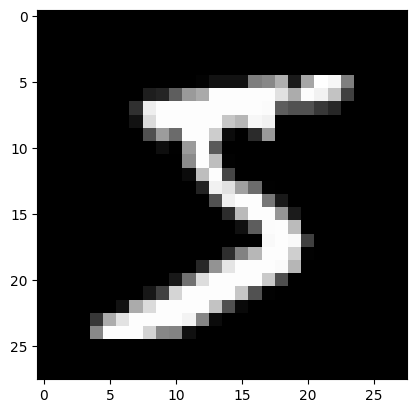

(50000, 784)


In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

### Convert to Tensor
Convert all data to tensors

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Simple Model
Simple linear model for starters

In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [33]:
print(weights.shape, bias.shape)

torch.Size([784, 10]) torch.Size([10])


** Log Softmax **

Log softmax involves taking log of softmax function. It simplifies to:

log(exp(xi)/sum(exp(xi)))
= xi - log(sum(exp(xi)))

In [ ]:
def log_softmax(x): # Defining softmax 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [9]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.8457, -2.1009, -2.5715, -2.3403, -2.6049, -1.6739, -1.9808, -2.3817,
        -2.5670, -2.5471], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [41]:
torch.argmax(preds, dim=1) # Getting the digit predictions for each item in the mini-batch

tensor([5, 5, 1, 5, 2, 8, 8, 5, 2, 5, 5, 9, 2, 3, 6, 5, 5, 5, 4, 5, 8, 5, 5, 5,
        5, 5, 2, 2, 5, 7, 6, 1, 7, 5, 5, 5, 7, 5, 7, 5, 6, 5, 2, 5, 2, 2, 5, 5,
        2, 5, 1, 5, 3, 5, 2, 5, 5, 5, 8, 5, 4, 3, 5, 4])

In [39]:
yb

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

In [ ]:
preds[0,yb[0]] # We want the value for the target digit to be maximized.
# So we minimize the negative of this function. That is negative log likelihood loss.

tensor(-2.5471, grad_fn=<SelectBackward0>)

In [ ]:
def nll(input, target): # negative log likelihood loss function
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4839, grad_fn=<NegBackward0>)


In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.0938)


In [44]:
(n - 1) // bs + 1

782

In [48]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        # Getting the batch for current iteration
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        # Getting predictions (forward pass)
        pred = model(xb)

        # Getting loss
        loss = loss_func(pred, yb)

        # Automatic backward prop using pytorch
        loss.backward()

        # Updating weights
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 0, Loss: 0.17590491473674774
Epoch: 1, Loss: 0.16923442482948303


In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0827, grad_fn=<NegBackward0>) tensor(1.)


In [54]:
torch.argmax(model(x_valid), dim=1) # Predictions for validation set

tensor([3, 8, 6,  ..., 5, 6, 8])

In [55]:
print(accuracy(model(x_valid), y_valid))

tensor(0.9250)
